In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from Project_Gas_Library import f_EIA_ListSeries, f_EIA_ExtractData, f_PlotData, f_EIA_PlotData, f_EIA_PlotData_Mod,\
f_WorldWeather_ExtractData, f_PlotData, f_Census_ExtractData, calculate_color, f_strToDate, f_EIA_ExtractData_Range, \
f_EIA_PlotData_Range, f_EIA_PlotData_Mod_Range, f_EIA_PlotData_Stack_Range, adf, RMSE

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA

#from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from datetime import datetime
from dateutil.relativedelta import relativedelta
from calendar import monthrange

from config import worldweather_key, g_key, EIA_key, census_key

from matplotlib.pyplot import cm
from citipy import citipy
from pprint import pprint

from matplotlib.cm import viridis
from matplotlib.colors import to_hex

In [2]:
#Defining variables to extract data from EIA
eia_api_key = EIA_key
url = "http://api.eia.gov/series/"

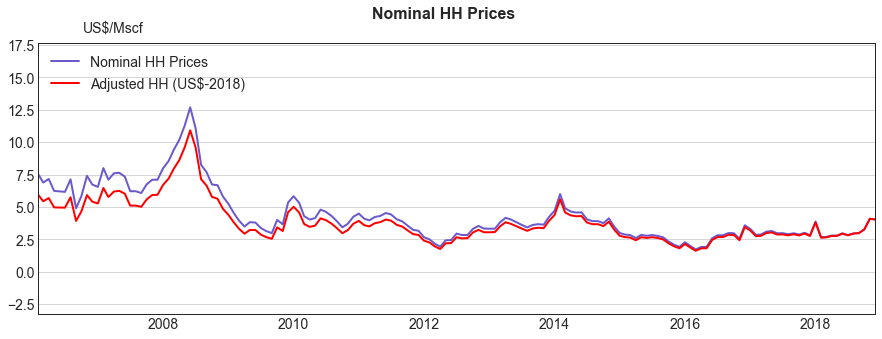

In [3]:
series_id_price = "NG.RNGWHHD.D" #HH

# extract daily price data
ini_date = "2006-1-1"
end_date = "2018-12-31"
lx_hh_d, ly_hh_d, title_hh_d, country_hh_d, unit_hh_d = f_EIA_ExtractData_Range(url,eia_api_key,series_id_price,ini_date,end_date)

#convert output to a dictionary
d_hh = {
    "Date": lx_hh_d,
    "HH Price":ly_hh_d
}

#convert the dictionary to a dataframe 
df_hh = pd.DataFrame(d_hh)
# making the date column a panda date variable
df_hh["Date"]= pd.to_datetime(df_hh['Date'])

#convert the daily data to monthly data (Aggregation helps to reduce volatility !!!!!!!!)
df_hh = df_hh.set_index('Date')
df_hh_m = df_hh.resample('MS').mean()
df_hh_m.reset_index(inplace=True)

# converting panda date type to object
for index, row in df_hh_m.iterrows():
    str_date = str(row["Date"].year) + "-" + str(row["Date"].month) + "-" + str(row["Date"].day)
    df_hh_m.loc[index,"Date_1"] = datetime.strptime(str_date,'%Y-%m-%d').date()
del df_hh_m['Date']
df_hh_m = df_hh_m.rename(columns={'Date_1': 'Date'})

#Obtaining the CPI values
file = "CPIAUCSL.csv"
df_cpi = pd.read_csv(file)
# making the date column a panda date variable
df_cpi["DATE"]= pd.to_datetime(df_cpi['DATE'])

df_cpi = df_cpi.rename(columns={'DATE': 'Date',"CPIAUCSL" :"CPI"})

# converting panda date type to object
for index, row in df_cpi.iterrows():
    str_date = str(row["Date"].year) + "-" + str(row["Date"].month) + "-" + str(row["Date"].day)
    df_cpi.loc[index,"Date_1"] = datetime.strptime(str_date,'%Y-%m-%d').date()
del df_cpi['Date']
df_cpi = df_cpi.rename(columns={'Date_1': 'Date'})

#Creating a dataframe that storage info related to HH
df_HH = df_hh_m.merge(df_cpi,on="Date",how="inner")

# Correcting HH prices by inflation using CPI - the objective is to convert prices to US$ 2018
maxDate = df_HH["Date"].max()
updCPI = df_HH.loc[df_HH["Date"]==maxDate,"CPI"]
updCPI=min(updCPI)
df_HH["CPI-2018"] = df_HH["CPI"]*1/updCPI
df_HH["HH Price Upd"] = df_HH["HH Price"]*df_HH["CPI-2018"]

#Creating the log Prices columns
df_HH["Log HH Price"] = np.log(df_HH["HH Price"])
df_HH["Log HH Price Upd"] = np.log(df_HH["HH Price Upd"])

#Creating Columns with shift
df_HH["Log HH Price Upd Shift 1"] = df_HH["Log HH Price Upd"].shift()
df_HH["Log HH Price Shift 1"] = df_HH["Log HH Price"].shift()
df_HH=df_HH.dropna()

#Ploting HH and adjusted HH Prices
title = "Nominal HH Prices"
unit = "US$/Mscf"
fig, ax = f_PlotData(df_HH["Date"],df_HH["HH Price"], title, unit)
ax.plot(df_HH["Date"],df_HH["HH Price Upd"], linewidth=2,color="red",label="Adjusted HH (US$-2018)")
ax.legend(loc='upper left')

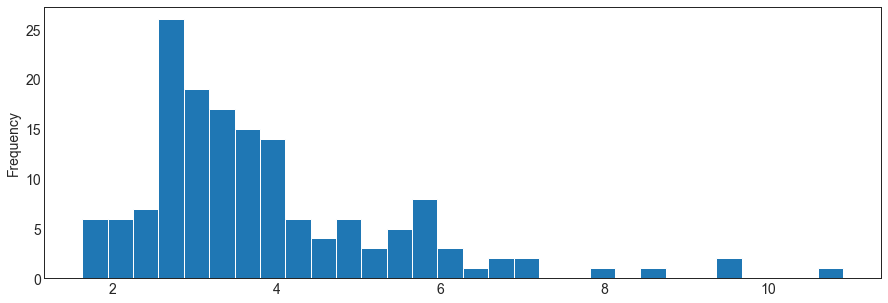

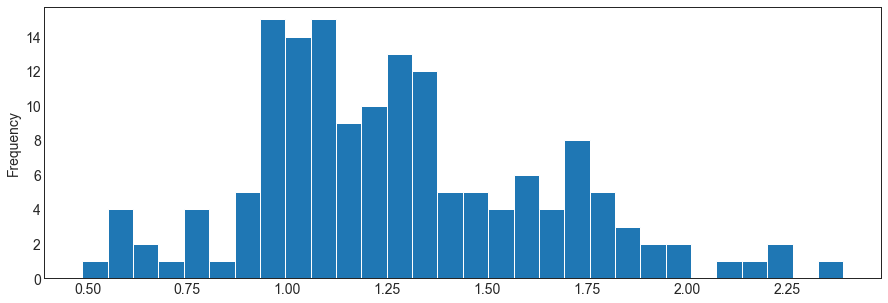

In [4]:
df_HH["HH Price Upd"].plot(kind="hist",bins = 30)
plt.show()
df_HH["Log HH Price Upd"].plot(kind="hist",bins = 30)
plt.show()

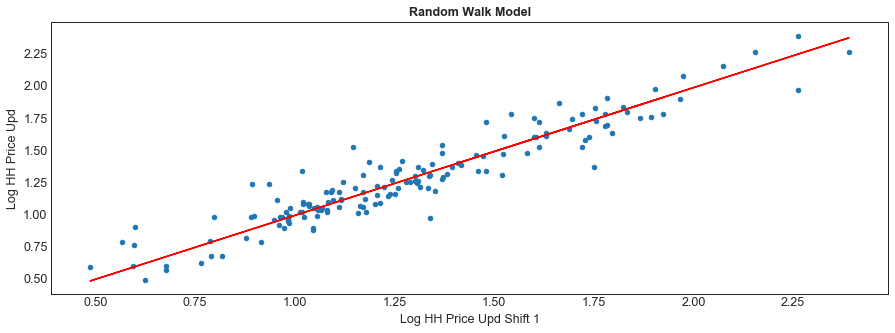

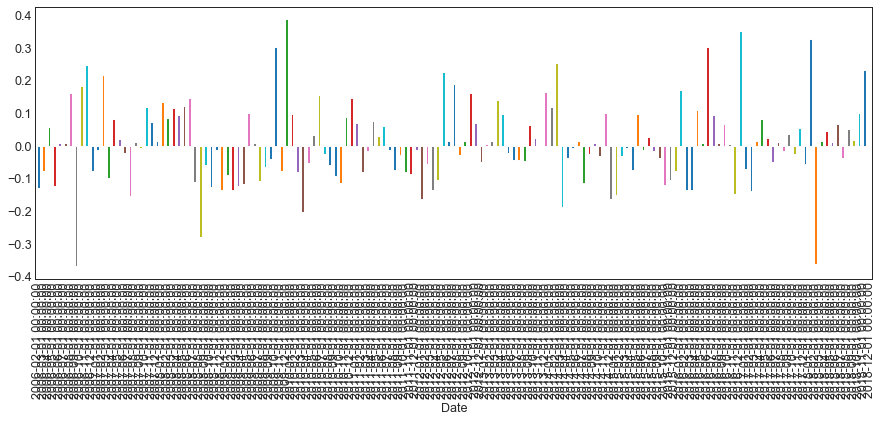

In [34]:
model_linear = sm.OLS(df_HH["Log HH Price Upd"], df_HH["Log HH Price Upd Shift 1"]).fit()
model_linear_pred = model_linear.predict()
df_HH["Log HH Price Upd Fitted"] = model_linear_pred


large = 16; med = 12.5; small = 11
params = {'axes.titlesize': med,
        'legend.fontsize': small,
        'figure.figsize': (15, 5),
        'axes.labelsize': med,
        'axes.titlesize': med,
        'xtick.labelsize': med,
        'ytick.labelsize': med,
        'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

df_HH.plot(kind="scatter",x="Log HH Price Upd Shift 1",y="Log HH Price Upd")
plt.plot(df_HH["Log HH Price Upd Shift 1"],df_HH["Log HH Price Upd Fitted"],c="r")

str_title = "Random Walk Model"
plt.title(str_title, fontweight="bold")
FileName ="Figures-Presentation/" + str_title + ".png"
plt.savefig(FileName)

plt.show()

model_linear.resid.plot(kind="bar")


In [6]:
print(model_linear.params)
R2 = model_linear.rsquared
pp = model_linear.pvalues
model_linear.summary()

Log HH Price Upd Shift 1    0.992602
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Log HH Price Upd   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 1.811e+04
Date:                Fri, 29 Mar 2019   Prob (F-statistic):          1.25e-161
Time:                        14:48:47   Log-Likelihood:                 106.20
No. Observations:                 155   AIC:                            -210.4
Df Residuals:                     154   BIC:                            -207.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Log HH Price Upd Shift 1     0.9926      0.007    134.588      0.000       0.978       1.007
==============================================================================
Omnibus:                        8.350   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               11.122
Skew:                           0.322   Prob(JB):                      0.00384
Kurtosis:                       4.144   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
pp

Log HH Price Upd Shift 1    1.253556e-161
dtype: float64

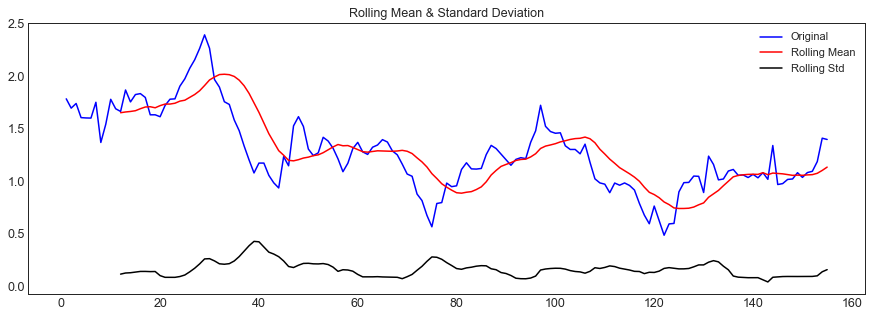

Test Statistic                  -2.325053
p-value                          0.164015
# of Lags Used                   0.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64

In [8]:
adf(df_HH["Log HH Price Upd"])

In [9]:
# Root Mean Squared Error (RMSE)
model_Exp_RMSE = RMSE(df_HH["Log HH Price Upd Shift 1"],df_HH["Log HH Price Upd"])
model_Exp_RMSE

0.12235518274879742

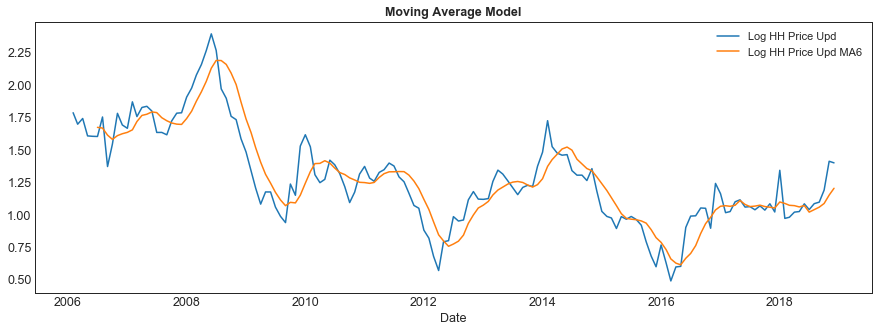

In [10]:
# For smoothing the values we can use 6 month Moving Averages

df_HH["Log HH Price Upd MA6"] = df_HH["Log HH Price Upd"].rolling(window=6).mean()
df_HH

large = 16; med = 12.5; small = 11
params = {'axes.titlesize': med,
        'legend.fontsize': small,
        'figure.figsize': (15, 5),
        'axes.labelsize': med,
        'axes.titlesize': med,
        'xtick.labelsize': med,
        'ytick.labelsize': med,
        'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

df_HH.plot(kind="line",x="Date",y=["Log HH Price Upd","Log HH Price Upd MA6"])

str_title = "Moving Average Model"
plt.title(str_title, fontweight="bold")
FileName ="Figures-Presentation/" + str_title + ".png"
plt.savefig(FileName)


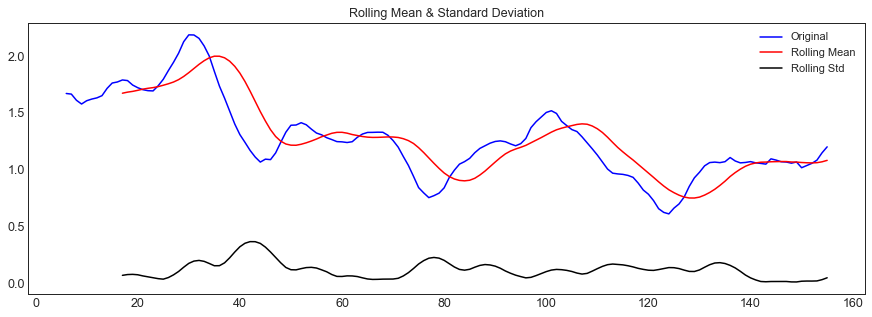

Test Statistic                  -2.284052
p-value                          0.177163
# of Lags Used                  14.000000
Number of Observations Used    135.000000
Critical Value (1%)             -3.479743
Critical Value (5%)             -2.883198
Critical Value (10%)            -2.578320
dtype: float64

In [11]:
df_MA6 = df_HH["Log HH Price Upd MA6"]
df_MA6 = df_MA6.dropna()
adf(df_MA6)

In [12]:
# Root Mean Squared Error (RMSE)
model_Exp_RMSE = RMSE(df_HH["Log HH Price Upd MA6"],df_HH["Log HH Price Upd"])
model_Exp_RMSE

0.15086905417834814

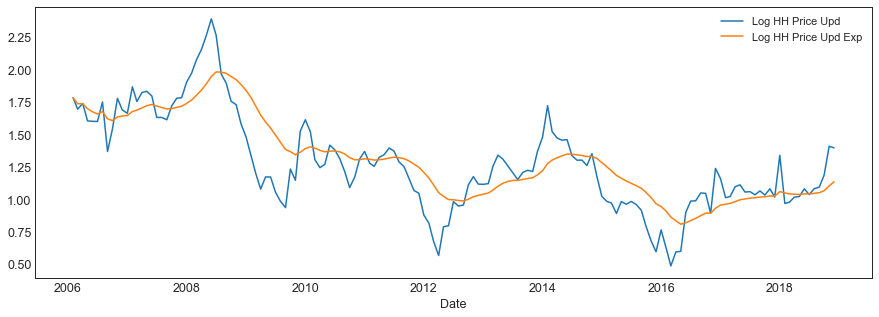

In [13]:
df_HH["Log HH Price Upd Exp"] = pd.DataFrame.ewm(df_HH["Log HH Price Upd"],halflife=6).mean()
df_HH.plot(kind="line",x="Date",y=["Log HH Price Upd","Log HH Price Upd Exp"])

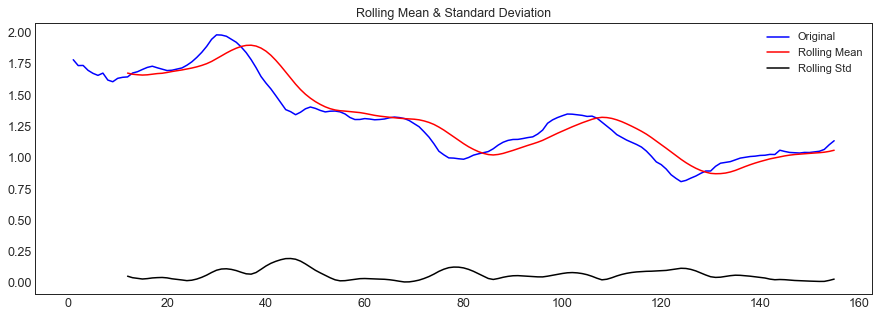

Test Statistic                  -1.641267
p-value                          0.461599
# of Lags Used                   1.000000
Number of Observations Used    153.000000
Critical Value (1%)             -3.473830
Critical Value (5%)             -2.880623
Critical Value (10%)            -2.576945
dtype: float64

In [14]:
adf(df_HH["Log HH Price Upd Exp"])

In [15]:
# Root Mean Squared Error (RMSE)
model_Exp_RMSE = RMSE(df_HH["Log HH Price Upd Exp"],df_HH["Log HH Price Upd"])
model_Exp_RMSE

0.2017702213972472

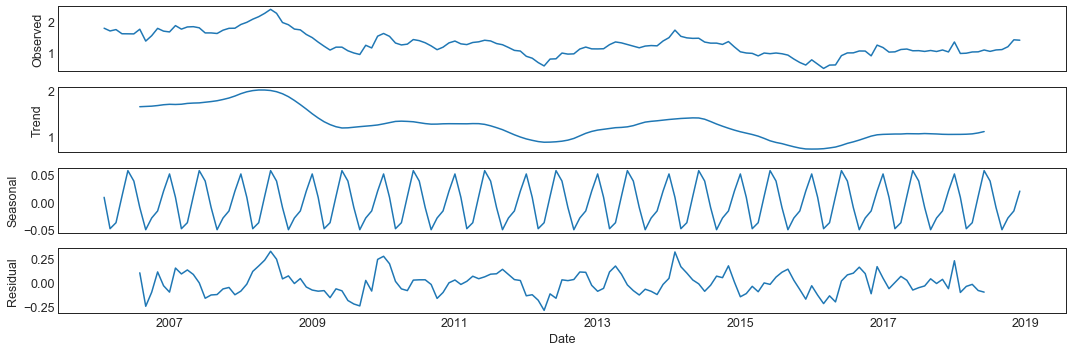

In [16]:
df_HH["Date"] = pd.to_datetime(df_HH["Date"])
df_HH = df_HH.set_index('Date')
df_HH.head()

#decomposition = seasonal_decompose(df_HH["Log HH Price Upd"], model = "multiplicative")
decomposition = seasonal_decompose(df_HH["Log HH Price Upd"], model = "additive")

decomposition.plot()

str_title = "Decomposition Model"
#plt.title(str_title, fontweight="bold")
FileName ="Figures-Presentation/" + str_title + ".png"
plt.savefig(FileName)

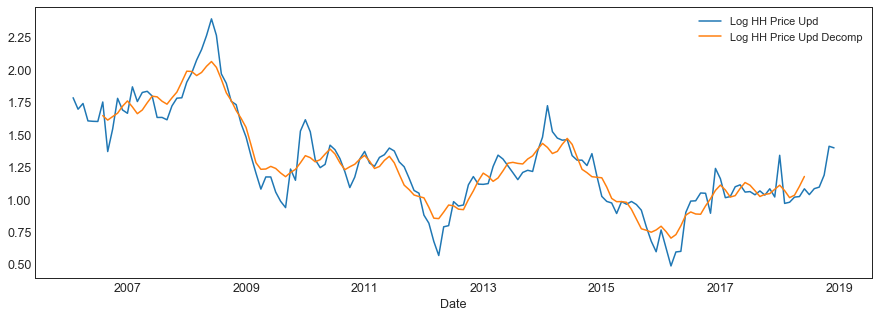

In [17]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

df_HH["Log HH Price Upd Decomp"] = trend + seasonal

df_HH.plot(kind="line",y=["Log HH Price Upd","Log HH Price Upd Decomp"])


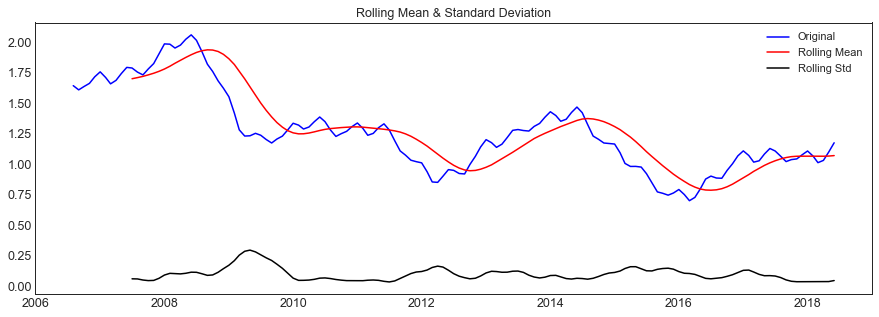

Test Statistic                  -2.626752
p-value                          0.087593
# of Lags Used                  14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64

In [18]:
ts_decomp = df_HH["Log HH Price Upd Decomp"]
ts_decomp = ts_decomp.dropna()
adf(ts_decomp)

In [19]:
# Root Mean Squared Error (RMSE)
model_Exp_RMSE = RMSE(df_HH["Log HH Price Upd Decomp"],df_HH["Log HH Price Upd"])
model_Exp_RMSE

0.11701645519964148

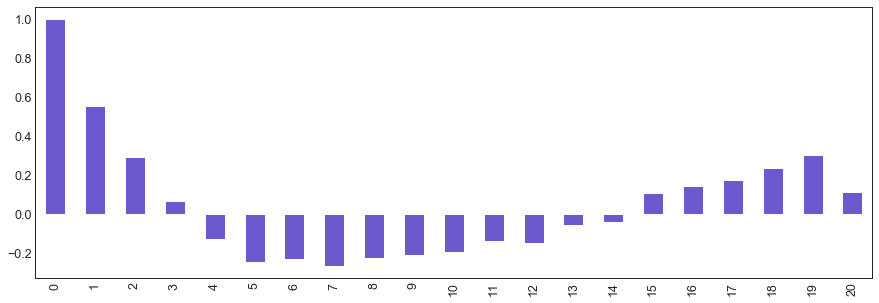

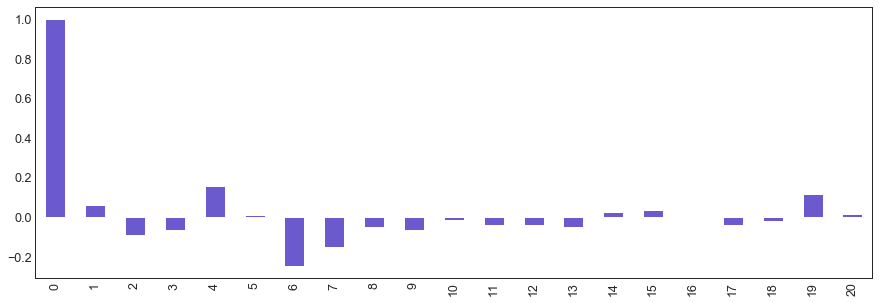

In [20]:
df_hh["Log HH Price Upd Diff"] = df_HH["Log HH Price Upd"] - df_HH["Log HH Price Upd Shift 1"]

#ts = df_HH["Log HH Price Upd"]
ts = residual
ts = ts.dropna()
ts_diff = df_hh["Log HH Price Upd Diff"]
ts_diff.dropna(inplace = True)

log_acf = acf(ts,nlags=20)
ACF_log = pd.Series(log_acf)
ACF_log.plot(kind = "bar",color="Slateblue")
plt.show()

lag_log_acf = acf(ts_diff, nlags=20)
ACF_lag_log = pd.Series(lag_log_acf)
ACF_lag_log.plot(kind = "bar",color="Slateblue")
plt.show()

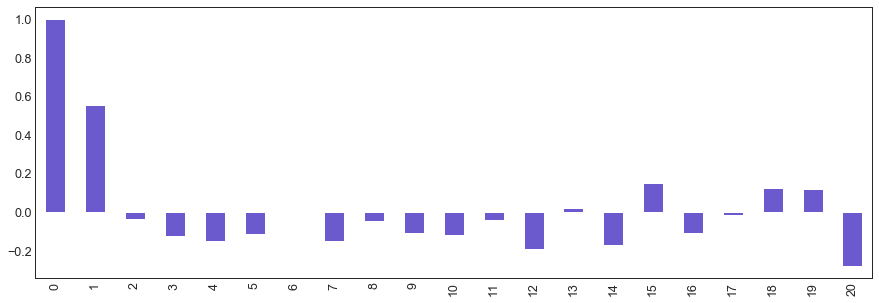

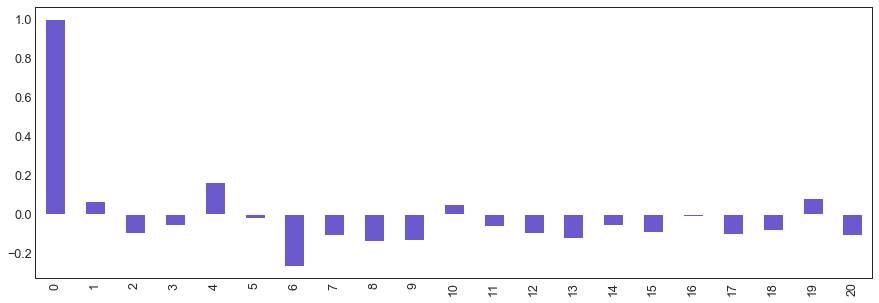

In [21]:
log_pacf = pacf(ts,nlags=20, method='ols')
PACF_log = pd.Series(log_pacf)
PACF_log.plot(kind = "bar",color="Slateblue")
plt.show()

lag_log_pacf = pacf(ts_diff, nlags=20, method='ols')
PACF_lag_log = pd.Series(lag_log_pacf)
PACF_lag_log.plot(kind = "bar",color="Slateblue")
plt.show()

The KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test tests for the null hypothesis that the series is trend stationary. In other words, if the p-value of the test statistic is below the X% confidence threshold, this means we can reject this hypothesis and that the series is not trend-stationary with X% confidence. A p-value higher than the threshold will lead us to accept this hypothesis and conclude that the series is trend-stationary.

In [33]:
print(" > Is the data stationary ?")
#dftest = kpss(df_HH["Log HH Price Upd"], 'ct')
dftest = kpss(ts, 'ct')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[3].items():
    print("\t{}: {}".format(k, v))

 > Is the data stationary ?
Test statistic = 0.049
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


C:\Users\Asterion\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Since the null hypotesis it "The series trends stationary" and p > 0.05; therefore we CAN NOT reject this hypothesis. Additionaly, the Test-statistic is below the critical values. This fact also leads to interpret that we CAN NOT reject the null hypothesis.

In [23]:
# Running the ARIMA Model(1,0,1)
# model_AR1MA = ARIMA(ts_diff, order=(1,0,1))
model_AR1MA = ARIMA(ts, order=(1,0,1))
#results_ARIMA = model_AR1MA.fit(disp = -1)
results_ARIMA = model_AR1MA.fit()
results_ARIMA.fittedvalues.head()
results_ARIMA.summary()

C:\Users\Asterion\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:       Log HH Price Upd   No. Observations:                  143
Model:                     ARMA(1, 1)   Log Likelihood                 130.328
Method:                       css-mle   S.D. of innovations              0.097
Date:                Fri, 29 Mar 2019   AIC                           -252.655
Time:                        14:48:52   BIC                           -240.804
Sample:                    08-01-2006   HQIC                          -247.839
                         - 06-01-2018                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0006      0.018     -0.035      0.972      -0.035       0.034
ar.L1.Log HH Price Upd     0.5207      0.116      4.472      0.000       0.292       0.749
ma.L1.Log HH Price Upd     0.0520      0.132      0.395      0.693      -0.206       0.310
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9207           +0.0000j            1.9207            0.0000
MA.1          -19.2478           +0.0000j           19.2478            0.5000
-----------------------------------------------------------------------------
"""

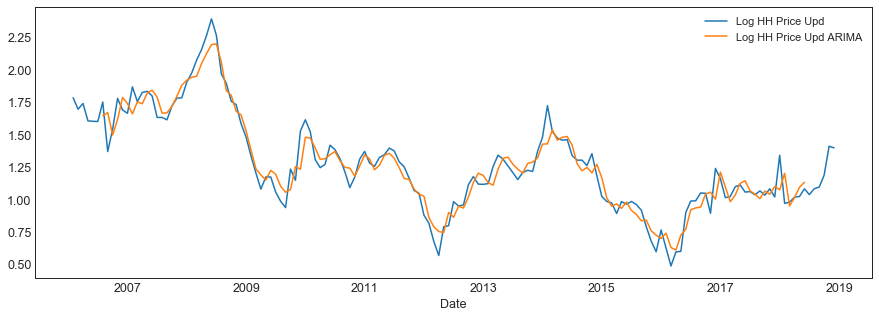

In [24]:
df_HH['Log HH Price Upd ARIMA'] = results_ARIMA.fittedvalues + trend + seasonal
df_HH.plot(kind="line", y = ["Log HH Price Upd", "Log HH Price Upd ARIMA"])

In [25]:
# Root Mean Squared Error (RMSE)
model_Exp_RMSE = RMSE(df_HH["Log HH Price Upd ARIMA"],df_HH["Log HH Price Upd"])
model_Exp_RMSE

0.0972653624380651

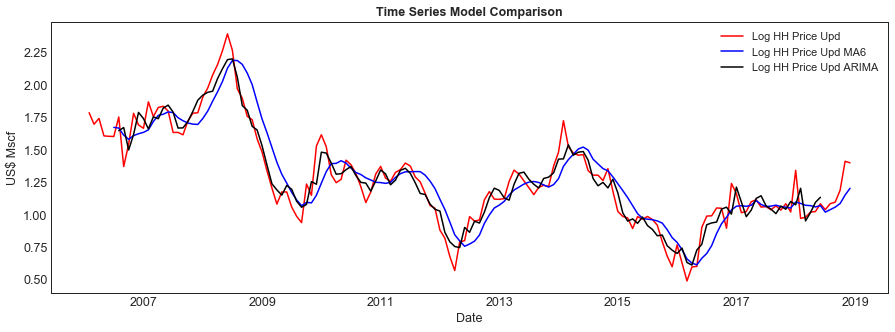

In [29]:
large = 16; med = 12.5; small = 11
params = {'axes.titlesize': med,
        'legend.fontsize': small,
        'figure.figsize': (15, 5),
        'axes.labelsize': med,
        'axes.titlesize': med,
        'xtick.labelsize': med,
        'ytick.labelsize': med,
        'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

styles = ['r-','b',"k"]
df_HH.plot(kind="line", y = ["Log HH Price Upd","Log HH Price Upd MA6","Log HH Price Upd ARIMA"],
          style=styles)

str_title = "Time Series Model Comparison"
plt.title(str_title, fontweight="bold")
FileName ="Figures-Presentation/" + str_title + ".png"
plt.ylabel("US$ Mscf")
plt.savefig(FileName)

plt.show()